# Quick start: using Bayesdawn on a simple example (with PSD estimator)

## 0. Import relevant modules

In [1]:
from bayesdawn import datamodel, psdmodel
from bayesdawn.utils import postprocess
import numpy as np
import random
import time
from scipy import signal, interpolate
from scipy.stats import norm
from matplotlib import pyplot as plt

MLDC modules could not be loaded.
MLDC modules could not be loaded.
MLDC modules could not be loaded.


## 1. Generate example data

To begin with, we generate some simple time series which contains noise and signal. To generate the noise, we start with a white, zero-mean Gaussian noise that we then transform it to obtain a stationary colored noise. This may be either by applying a filter, or by directly applying a specified PSD in frequency space.

In [2]:
# Choose size of data
upscale_fac=1
n_data = 2**14*upscale_fac
# Set sampling frequency
fs = 1.0*upscale_fac
# Generate Gaussian white noise
noise = np.random.normal(loc=0.0, scale=1.0, size = n_data)
#Color according to a specified PSD
noisePSDfunc=lambda f: 1/(1+10000./(1+(f/2e-2)**(4/np.log10(5))))
f = np.fft.rfftfreq(n_data) * fs
#now we use noise as noise for Re/Im parts of white FFT
#Need to check that this correctly assumes a "one-sided" PSD
n_fft=noise[0:n_data//2+1]+0*1j #complex white noise real part (n_data assumed even )
n_fft[1:]=n_fft[1:]+1j*noise[n_data//2:] #complex white noise imag part (zeros at ends!)
sqrtS=np.sqrt(np.apply_along_axis(noisePSDfunc,0,f))
print('2df',f[2]-f[0],1/(n_data*fs/2))
n_fft=sqrtS*n_fft*np.sqrt(n_data*fs/4)
n=np.fft.irfft(n_fft)

2df 0.0001220703125 0.0001220703125


Then we need a deterministic signal to add. We choose a sinusoid with some frequency $f_0$ and amplitude $a_0$:

In [3]:
# Creation of deterministic signal
t = np.arange(0, n_data) / fs
f0 = 1e-2
a0 = 5e-3
s = a0 * np.sin(2 * np.pi * f0 * t)
# Adding signal to noise
y = s + n

Now assume that some data are missing, i.e. the time series is cut by random gaps. The pattern is represented by a mask vector with entries equal to 1 when data is observed, and 0 otherwise:

In [4]:
mask = np.ones(n_data)
n_gaps = 30
gapstarts = (n_data * np.random.random(n_gaps)).astype(int)
gaplength = 10*fs #Gap is a fixed size in time.
gapends = (gapstarts+gaplength).astype(int)
for k in range(n_gaps): mask[gapstarts[k]:gapends[k]]= 0
# Masked data:
y_masked = mask * y

## 2. Define your PSD estimator

We assume that we don't know the PSD and we want to estimate it from the data.
For that, we adopt a spline model for the log-PSD.

In [5]:
# Observation time
t_obs = n_data / fs
# Lower frequency for the PSD estimation
fmin = 1 / t_obs * 1.05
# Upper frequency
fmax=fs/2
# Instantiate PSD estimator class
psd_cls = psdmodel.PSDSpline(n_data, fs,
                                n_knots=20,
                                d=3,
                                fmin=fmin,
                                fmax=fmax,
                                ext=0)

## 3. Check that the PSD estimator is consistent with the data

In [6]:
# Do an estimation of the PSD on the full data
psd_cls.estimate(y)
psd_estimate = psd_cls.calculate(f[f>0])
# But in real-world situation we only have access to the masked data
psd_cls.estimate(y_masked)
psd_estimate_gaps = psd_cls.calculate(f[f>0])

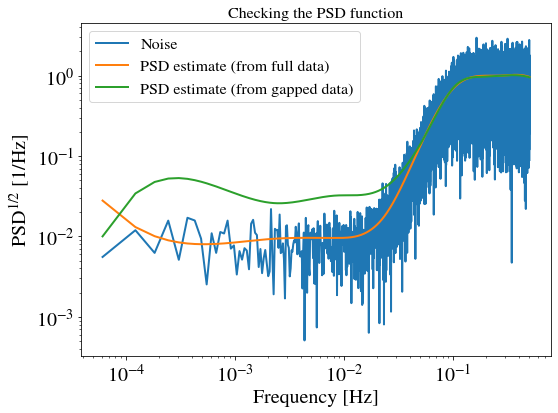

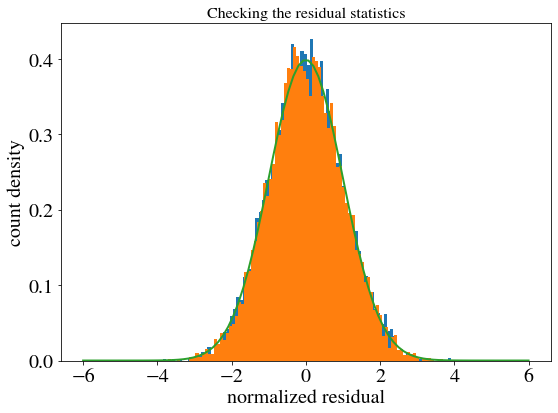

In [7]:
f = np.fft.rfftfreq(n_data) * fs
n_fft = np.fft.rfft(n)
scalefac=np.sqrt(2 / (n_data*fs))
# Load plotting configuration
postprocess.plotconfig(lbsize=20, lgsize=16, autolayout=True, figsize=(8, 6),
                       ticklabelsize=20)
# Plot data against PSD
fig, ax = plt.subplots()
ax.set_title(r"Checking the PSD function")
ax.set_xlabel(r"Frequency [Hz]")
ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
ax.loglog(f[f>0], np.abs(n_fft[f>0]) * scalefac, label="Noise")
ax.loglog(f[f>0], np.sqrt(psd_estimate), label="PSD estimate (from full data)")
ax.loglog(f[f>0], np.sqrt(psd_estimate_gaps), label="PSD estimate (from gapped data)")
plt.legend()
plt.show()
#Check the statistics on the residual
df=fs/n_data
nbins=int(np.sqrt(len(n_fft)))
plt.hist(n_fft.real[f>0]*scalefac/np.sqrt(psd_estimate/2),bins=nbins,density=True,label="real part")
plt.hist(n_fft.imag[f>0]*scalefac/np.sqrt(psd_estimate/2),bins=nbins,density=True,label='imag part')
x=np.linspace(-6,6,nbins)
plt.plot(x,norm.pdf(x))
plt.title(r"Checking the residual statistics")
plt.xlabel(r"normalized residual")
plt.ylabel(r"count density") 
plt.show()

## 3. Instantiate the imputation class

From the signal and noise models, we can instantiate the GaussianStationaryProcess class from the datamodel module:

In [8]:
# instantiate imputation class
imp_cls = datamodel.GaussianStationaryProcess(s, mask, psd_cls, method='nearest', na=50*fs, nb=50*fs)
# perform offline computations
imp_cls.compute_offline()

Computation of autocovariance + PSD took 0.003371000289916992


## 4. Perform missing data imputation

We can reconstruct the missing data with the impute method of the GaussianStationaryProcess. Since we don't know the PSD, we need to do a few iterations of reconstruction / PSD estimations to converge.

In [9]:
# Number of iterations
n_iter = 6
# Initialize the (reconstructed) data residuals
y_res = mask * (y_masked - s)
for i in range(n_iter):
    t1 = time.time()
    # Estimate PSD from reconstructed data residuals
    psd_cls.estimate(y_res)
    # Pass the updated PSD model to the imputation class
    imp_cls.update_psd(psd_cls)
    # Re-compute of PSD-dependent terms
    imp_cls.compute_offline()
    # Imputation of missing data by randomly drawing from their conditional distribution
    y_rec = imp_cls.impute(y_masked, draw=True)
    # Update the data residuals
    y_res = y_rec - s
    t2 = time.time()
    print("The imputation / PSD estimation iteration took " + str(t2-t1))

Computation of autocovariance + PSD took 0.0015408992767333984
The imputation / PSD estimation iteration took 0.6933879852294922
Computation of autocovariance + PSD took 0.0021660327911376953
The imputation / PSD estimation iteration took 0.4074537754058838
Computation of autocovariance + PSD took 0.002256155014038086
The imputation / PSD estimation iteration took 0.3678090572357178
Computation of autocovariance + PSD took 0.001683950424194336
The imputation / PSD estimation iteration took 0.3973402976989746
Computation of autocovariance + PSD took 0.0016601085662841797
The imputation / PSD estimation iteration took 0.3855412006378174
Computation of autocovariance + PSD took 0.002028942108154297
The imputation / PSD estimation iteration took 0.4004099369049072


To see whether the imputation gives statisfactory statistics, we will compare the imputed data to the original one in Fourier domain. We start by Fourier-transforming the data:

In [10]:
# Fourier transform the results and the input data
y_fft = np.fft.rfft(y)
y_masked_fft = np.fft.rfft(y_masked)
y_rec_fft = np.fft.rfft(y_rec)

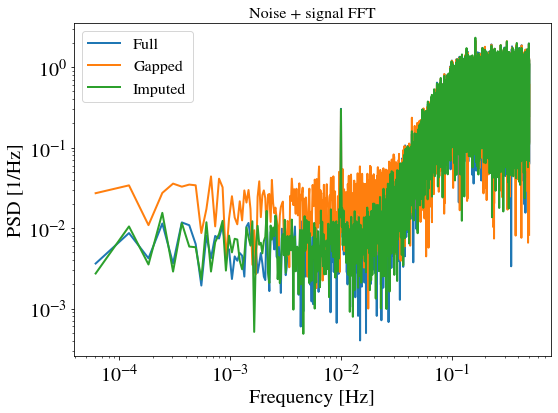

In [11]:
# Plot results
fig, ax = plt.subplots()
ax.set_title(r"Noise + signal FFT")
ax.set_xlabel(r"Frequency [Hz]")
ax.set_ylabel(r"PSD [1/Hz]") 
ax.loglog(f[f>0], np.abs(y_fft[f>0])/np.sqrt(n_data*fs), label="Full")
ax.loglog(f[f>0], np.abs(y_masked_fft[f>0])/np.sqrt(n_data*fs), label="Gapped")
ax.loglog(f[f>0], np.abs(y_rec_fft[f>0])/np.sqrt(n_data*fs), label="Imputed")
plt.legend()
plt.show()

In [12]:
# Compare imputed residuals with true noise
y_res_fft = np.fft.rfft(y_res)
# Get the PSD estimate from last residuals
psd_cls.estimate(y_res)
psd_estimate_final = psd_cls.calculate(f[f>0])

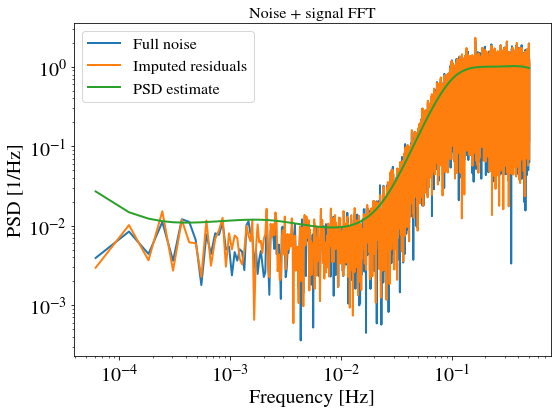

In [15]:
# Plot results
fig, ax = plt.subplots()
ax.set_title(r"Noise + signal FFT")
ax.set_xlabel(r"Frequency [Hz]")
ax.set_ylabel(r"PSD [1/Hz]") 
ax.loglog(f[f>0], np.abs(n_fft[f>0])/np.sqrt(n_data*fs), 
        label="Full noise")
ax.loglog(f[f>0], np.abs(y_res_fft[f>0])/np.sqrt(n_data*fs), 
         label="Imputed residuals")
ax.loglog(f[f>0], np.sqrt(psd_estimate_final), 
          label="PSD estimate")
plt.legend()
plt.show()